# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from scipy.spatial import distance
from sklearn.metrics.pairwise import manhattan_distances

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Load Preporcessed Dataset

In [3]:
# loading images
images_real = load_obj_real("ffhq_64_64")
images_sn = load_obj_real("SNGAN_Steffen_ffhq_64_64")
images_dc = load_obj_real("DCGAN_Steffen_ffhq_64_64")
images_fid = load_obj_real("SNGAN_FID_Steffen_ffhq_64_64")
images_style3 = load_obj_real("stylegan3_Steffen_ffhq_64_64")

Real Images: 70000
SN Images: 49950
DC Images: 49950
FID Images: 49949
Style Images: 70000


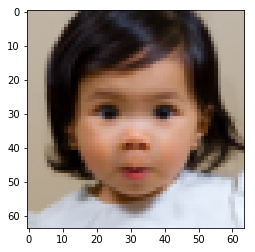

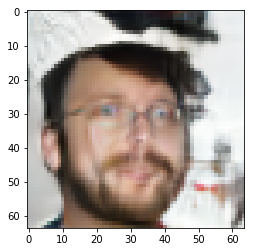

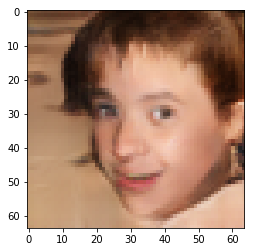

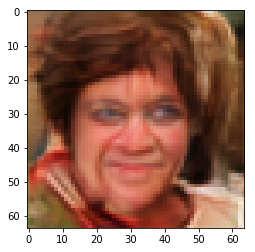

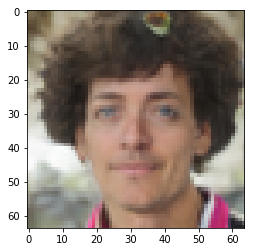

In [4]:
# Example image
print("Real Images:", len(images_real))
print("SN Images:", len(images_sn))
print("DC Images:", len(images_dc))
print("FID Images:", len(images_fid))
print("Style Images:", len(images_style3))
imgplot = plt.imshow(images_real[3])
plt.show()
imgplot = plt.imshow(images_sn[3])
plt.show()
imgplot = plt.imshow(images_dc[3])
plt.show()
imgplot = plt.imshow(images_fid[3])
plt.show()
imgplot = plt.imshow(images_style3[3])
plt.show()

## Real Images

# Analyzing Images

## Creating FFT

In [5]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

# Create Informations
def create_informations(images):
    two_dim = fft(images[0])
    m,n = two_dim.shape
    zero_axis = np.sum(fft(images[0]), axis=0)/m
    one_axis = np.sum(fft(images[0]), axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(fft(images[0]), axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(fft(images[0]), axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        std_zero_axis = std_zero_axis + ((np.sum(fft(images[i]), axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft(images[i]), axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

Text(0.5, 0.98, 'Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 - left: colomn wise right: row-wise')

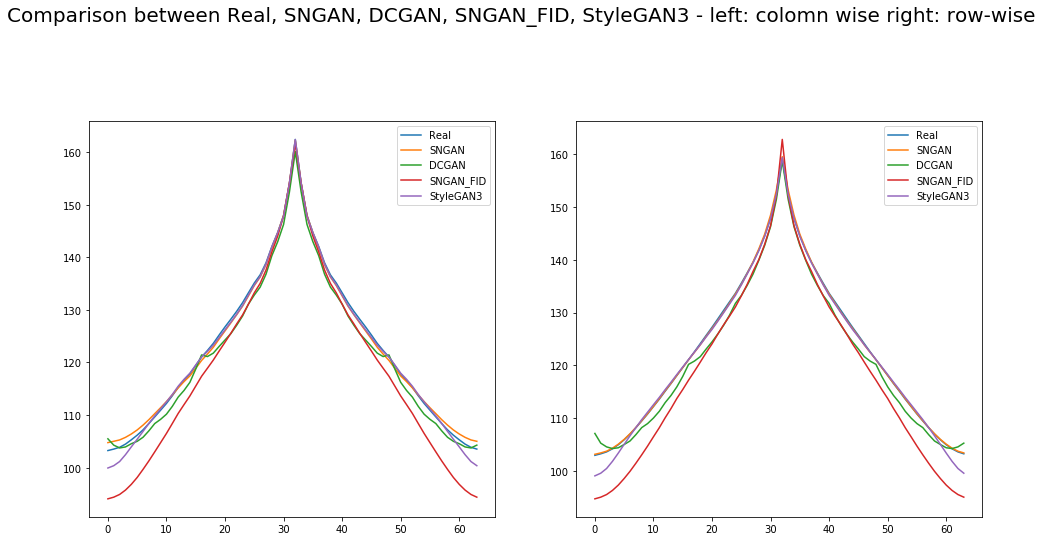

In [6]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
two_dim_s, zero_axis_s, one_axis_s, m_s, n_s,min_zero_axis_s,max_zero_axis_s, min_one_axis_s, max_one_axis_s, std_zero_axis_s, std_one_axis_s = create_informations(images_sn)
two_dim_d, zero_axis_d, one_axis_d, m_d, n_d,min_zero_axis_d,max_zero_axis_d, min_one_axis_d, max_one_axis_d, std_zero_axis_d, std_one_axis_d = create_informations(images_dc)
two_dim_f, zero_axis_f, one_axis_f, m_f, n_f,min_zero_axis_f,max_zero_axis_f, min_one_axis_f, max_one_axis_f, std_zero_axis_f, std_one_axis_f = create_informations(images_fid)
two_dim_style, zero_axis_style, one_axis_style, m_style, n_style,min_zero_axis_style,max_zero_axis_style, min_one_axis_style, max_one_axis_style, std_zero_axis_style, std_one_axis_style = create_informations(images_style3)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_s)),zero_axis_s, label='SNGAN')
ax1.plot(range(len(zero_axis_d)),zero_axis_d, label='DCGAN')
ax1.plot(range(len(zero_axis_f)),zero_axis_f, label='SNGAN_FID')
ax1.plot(range(len(zero_axis_style)),zero_axis_style, label='StyleGAN3')

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_s)),one_axis_s, label='SNGAN')
ax2.plot(range(len(one_axis_d)),one_axis_d, label='DCGAN')
ax2.plot(range(len(one_axis_f)),one_axis_f, label='SNGAN_FID')
ax2.plot(range(len(one_axis_style)),one_axis_style, label='StyleGAN3')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 - left: colomn wise right: row-wise')

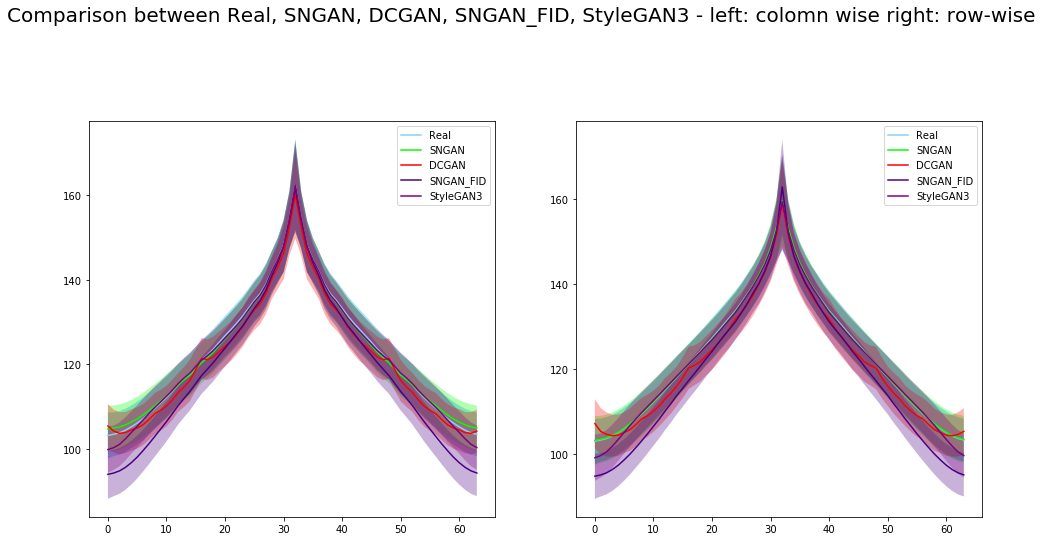

In [7]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_s)),zero_axis_s, label='SNGAN', color ='lime')
ax1.fill_between(range(m_s), zero_axis_s + std_zero_axis_s, zero_axis_s -std_zero_axis_s,facecolor='lime', alpha=0.3)
ax1.plot(range(len(zero_axis_d)),zero_axis_d, label='DCGAN', color ='red')
ax1.fill_between(range(m_d), zero_axis_d + std_zero_axis_d, zero_axis_d -std_zero_axis_d,facecolor='red', alpha=0.3)
ax1.plot(range(len(zero_axis_f)),zero_axis_f, label='SNGAN_FID', color ='indigo')
ax1.fill_between(range(m_f), zero_axis_f+ std_zero_axis_f, zero_axis_f -std_zero_axis_f,facecolor='indigo', alpha=0.3)
ax1.plot(range(len(zero_axis_style)),zero_axis_style, label='StyleGAN3', color ='purple')
ax1.fill_between(range(m_style), zero_axis_style+ std_zero_axis_style, zero_axis_style -std_zero_axis_style,facecolor='purple', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_s)),one_axis_s, label='SNGAN',color = 'lime')
ax2.fill_between(range(m_s), one_axis_s + std_one_axis_s, one_axis_s -std_one_axis_s,facecolor='lime', alpha=0.3)
ax2.plot(range(len(one_axis_d)),one_axis_d, label='DCGAN',color = 'red')
ax2.fill_between(range(m_d), one_axis_d + std_one_axis_d, one_axis_d -std_one_axis_d,facecolor='red', alpha=0.3)
ax2.plot(range(len(one_axis_f)),one_axis_f, label='SNGAN_FID',color = 'indigo')
ax2.fill_between(range(m_f), one_axis_f + std_one_axis_f, one_axis_f -std_one_axis_f,facecolor='indigo', alpha=0.3)
ax2.plot(range(len(one_axis_style)),one_axis_style, label='StyleGAN3',color = 'purple')
ax2.fill_between(range(m_style), one_axis_style + std_one_axis_style, one_axis_style -std_one_axis_style,facecolor='purple', alpha=0.3)


leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 - left: colomn wise right: row-wise", fontsize=20)

In [9]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [10]:
print("KL-Divergence (column):")
print("SNGAN:", kl_divergence(zero_axis_r,zero_axis_s))
print("DCGAN:", kl_divergence(zero_axis_r,zero_axis_d))
print("SNGAN_FID:", kl_divergence(zero_axis_r,zero_axis_f))
print("StyleGAN3:", kl_divergence(zero_axis_r,zero_axis_style))
print()
print("KL-Divergence (row):")
print("SNGAN:", kl_divergence(one_axis_r,one_axis_s))
print("DCGAN:", kl_divergence(one_axis_r,one_axis_d))
print("SNGAN_FID:", kl_divergence(one_axis_r,one_axis_f))
print("StyleGAN3:", kl_divergence(one_axis_r,one_axis_style))
print()
print("KL-Divergence (col vs row):")
print("Real:", kl_divergence(zero_axis_r,one_axis_r))
print("SNGAN:", kl_divergence(zero_axis_s,one_axis_s))
print("DCGAN:", kl_divergence(zero_axis_d,one_axis_d))
print("SNGAN_FID:", kl_divergence(zero_axis_f,one_axis_f))
print("StyleGAN3:", kl_divergence(zero_axis_style,one_axis_style))

KL-Divergence (column):
SNGAN: -2.5195553255927017
DCGAN: 98.23815846860033
SNGAN_FID: 281.82106232393375
StyleGAN3: 30.339258853247788

KL-Divergence (row):
SNGAN: -2.6541063225904464
DCGAN: 98.4569117913482
SNGAN_FID: 281.1944757612433
StyleGAN3: 30.441813100686208

KL-Divergence (col vs row):
Real: 0.086142485263079
SNGAN: 0.2604998973058881
DCGAN: 0.0859904515282004
SNGAN_FID: 0.0775402815361943
StyleGAN3: 0.11166629648842497


In [12]:
print("Manhattan distance (column):")
print("SNGAN:", manhattan_distances([zero_axis_r],[zero_axis_s])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_r],[zero_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_r],[zero_axis_f])[0][0])
print("StyleGAN3:", manhattan_distances([zero_axis_r],[zero_axis_style])[0][0])
print()
print("Manhattan distance (row):")
print("SNGAN:", manhattan_distances([one_axis_r],[one_axis_s])[0][0])
print("DCGAN:", manhattan_distances([one_axis_r],[one_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([one_axis_r],[one_axis_f])[0][0])
print("StyleGAN3:", manhattan_distances([one_axis_r],[one_axis_style])[0][0])
print()
print("Manhattan distance (col vs row):")
print("Real:", manhattan_distances([zero_axis_r],[one_axis_r])[0][0])
print("SNGAN:", manhattan_distances([zero_axis_s],[one_axis_s])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_d],[one_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_f],[one_axis_f])[0][0])
print("StyleGAN3:", manhattan_distances([zero_axis_style],[one_axis_style])[0][0])

Manhattan distance (column):
SNGAN: 38.72827345188669
DCGAN: 106.45687305727216
SNGAN_FID: 273.8260351393768
StyleGAN3: 37.15313144508899

Manhattan distance (row):
SNGAN: 11.421443158394112
DCGAN: 117.7878108236333
SNGAN_FID: 281.3805832326031
StyleGAN3: 39.62397686947173

Manhattan distance (col vs row):
Real: 25.66577522173182
SNGAN: 55.69513112078654
DCGAN: 28.812443936703914
SNGAN_FID: 25.242841813039604
StyleGAN3: 31.480681780864913


In [13]:
print("Euclidean distance (column):")
print("SNGAN:", np.linalg.norm(zero_axis_r-zero_axis_s))
print("DCGAN:", np.linalg.norm(zero_axis_r-zero_axis_d))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r-zero_axis_f))
print("StyleGAN3:", np.linalg.norm(zero_axis_r-zero_axis_style))
print()
print("Euclidean distance (row):")
print("SNGAN:", np.linalg.norm(one_axis_r-one_axis_s))
print("DCGAN:", np.linalg.norm(one_axis_r-one_axis_d))
print("SNGAN_FID:", np.linalg.norm(one_axis_r-one_axis_f))
print("StyleGAN3:", np.linalg.norm(one_axis_r-one_axis_style))
print()
print("Euclidean distance (col vs row):")
print("Real:", np.linalg.norm(zero_axis_r-one_axis_r))
print("SNGAN:", np.linalg.norm(zero_axis_r-one_axis_r))
print("DCGAN:", np.linalg.norm(zero_axis_r-one_axis_r))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r-one_axis_r))
print("StyleGAN3:", np.linalg.norm(zero_axis_style-one_axis_style))

Euclidean distance (column):
SNGAN: 5.762165233919399
DCGAN: 14.368297901746123
SNGAN_FID: 40.80617450098722
StyleGAN3: 7.981861075576185

Euclidean distance (row):
SNGAN: 1.9880174324904099
DCGAN: 15.951376707190779
SNGAN_FID: 39.534747009119236
StyleGAN3: 9.156651846907652

Euclidean distance (col vs row):
Real: 5.006314534475022
SNGAN: 5.006314534475022
DCGAN: 5.006314534475022
SNGAN_FID: 5.006314534475022
StyleGAN3: 5.48684773836951


## Normalized

Text(0.5, 0.98, 'Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 (normalized) - left: colomn wise right: row-wise')

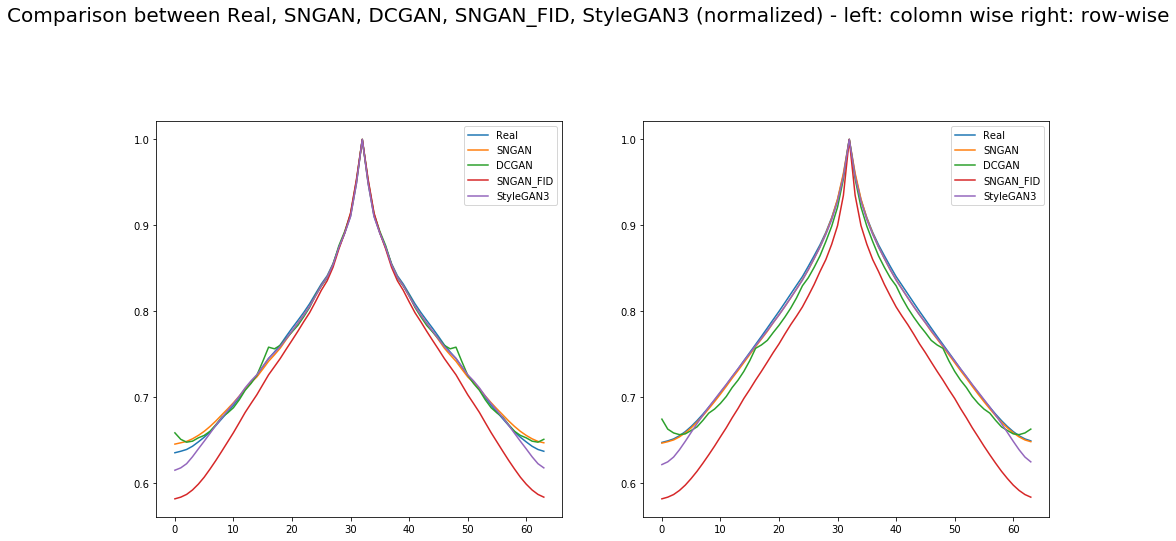

In [8]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_s)),zero_axis_s/zero_axis_s.max(), label='SNGAN')
ax1.plot(range(len(zero_axis_d)),zero_axis_d/zero_axis_d.max(), label='DCGAN')
ax1.plot(range(len(zero_axis_f)),zero_axis_f/zero_axis_f.max(), label='SNGAN_FID')
ax1.plot(range(len(zero_axis_style)),zero_axis_style/zero_axis_style.max(), label='StyleGAN3')

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_s)),one_axis_s/one_axis_s.max(), label='SNGAN')
ax2.plot(range(len(one_axis_d)),one_axis_d/one_axis_d.max(), label='DCGAN')
ax2.plot(range(len(one_axis_f)),one_axis_f/one_axis_f.max(), label='SNGAN_FID')
ax2.plot(range(len(one_axis_style)),one_axis_style/one_axis_style.max(), label='StyleGAN3')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, SNGAN, DCGAN, SNGAN_FID, StyleGAN3 (normalized) - left: colomn wise right: row-wise", fontsize=20)

In [10]:
print("KL-Divergence (column):")
print("SNGAN:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_s/zero_axis_s.max()))
print("DCGAN:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_d/zero_axis_d.max()))
print("SNGAN_FID:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_f/zero_axis_f.max()))
print("StyleGAN3:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_style/zero_axis_style.max()))
print()
print("KL-Divergence (row):")
print("SNGAN:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_s/one_axis_s.max()))
print("DCGAN:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_d/one_axis_d.max()))
print("SNGAN_FID:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_f/one_axis_f.max()))
print("StyleGAN3:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_style/one_axis_style.max()))

KL-Divergence (column):
SNGAN: -0.07141664185502092
DCGAN: -0.0887178558368034
SNGAN_FID: 1.490331137164058
StyleGAN3: 0.17627964725652112

KL-Divergence (row):
SNGAN: 0.1373681940151762
DCGAN: 0.543607174581406
SNGAN_FID: 2.9272908719638338
StyleGAN3: 0.2941470191481131


In [13]:
print("Manhattan distance (column):")
print("SNGAN:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_s/zero_axis_s.max()])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_d/zero_axis_d.max()])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_f/zero_axis_f.max()])[0][0])
print("StyleGAN3:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_style/zero_axis_style.max()])[0][0])
print()
print("Manhattan distance (row):")
print("SNGAN:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_s/one_axis_s.max()])[0][0])
print("DCGAN:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_d/one_axis_d.max()])[0][0])
print("SNGAN_FID:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_f/one_axis_f.max()])[0][0])
print("StyleGAN3:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_style/one_axis_style.max()])[0][0])

Manhattan distance (column):
SNGAN: 0.23046069686294346
DCGAN: 0.2446915807589638
SNGAN_FID: 1.484207674249932
StyleGAN3: 0.22525716040412735

Manhattan distance (row):
SNGAN: 0.14933996188333876
DCGAN: 0.6801517462880285
SNGAN_FID: 2.8275241133546403
StyleGAN3: 0.3015937530640702


In [12]:
print("Euclidean distance (column):")
print("SNGAN:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_s/zero_axis_s.max()))
print("DCGAN:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_d/zero_axis_d.max()))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_f/zero_axis_f.max()))
print("StyleGAN3:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_style/zero_axis_style.max()))
print()
print("Euclidean distance (row):")
print("SNGAN:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_s/one_axis_s.max()))
print("DCGAN:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_d/one_axis_d.max()))
print("SNGAN_FID:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_f/one_axis_f.max()))
print("StyleGAN3:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_style/one_axis_style.max()))

Euclidean distance (column):
SNGAN: 0.03608881111656177
DCGAN: 0.04443835202043301
SNGAN_FID: 0.2295555835974225
StyleGAN3: 0.04861247022244482

Euclidean distance (row):
SNGAN: 0.02090022418804621
DCGAN: 0.09311045383727605
SNGAN_FID: 0.3686558134446671
StyleGAN3: 0.06324450560423266
